# Ejemplo básico: Regresión Linea con California Housing

Este notebook usa el dataset **California Housing** incluido en `scikit-learn`.

**Objetivo:** predecir `MedHouseVal` (valor medio de vivienda) a partir de variables numéricas del censo.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 1. Cargar el dataset

In [3]:
# No cargamos los datos de un CSV, si no directamente de scikit-learn
data = fetch_california_housing(as_frame=True)

# Recupermos X e y porque vienen en campos independientes
X = data.data.copy()
y = data.target.copy()  # MedHouseVal

# Creamos el DataFrame df con todos los datos (X e y juntos)
df = X.copy()
df["MedHouseVal"] = y

df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. EDA (Exploración de datos)

En este EDA revisamos:
- tipos de variables (¿hay categóricas?)
- valores nulos
- duplicados
- estadísticos descriptivos
- distribución del target
- correlaciones
- outliers de forma básica


### Tipos de variables y comprobación de categóricas

In [4]:
df.dtypes

,0
MedInc,float64
HouseAge,float64
AveRooms,float64
AveBedrms,float64
Population,float64
AveOccup,float64
Latitude,float64
Longitude,float64
MedHouseVal,float64


**Comprobación rápida:** si hay columnas `object`, `category` o `bool` serían candidatas a categóricas.
En este dataset, todas son numéricas.


### Valores nulos

In [5]:
df.isna().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


El dataset no contiene nulos.


### Duplicados

In [6]:
df.duplicated().sum()

np.int64(0)

Tampoco contiene duplicados

### Outliers (análisis univariante)


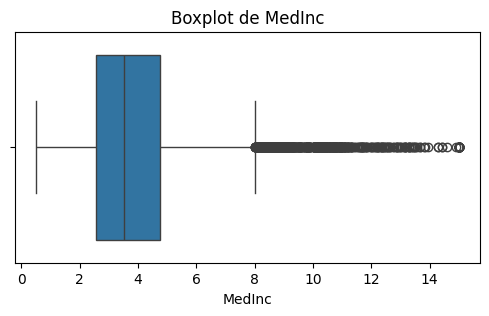

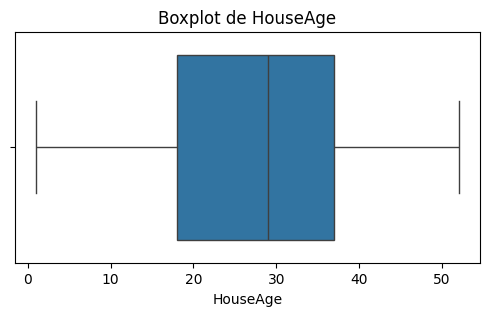

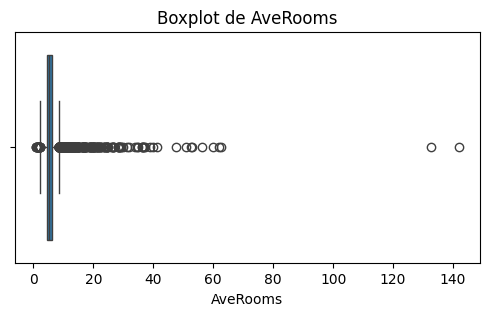

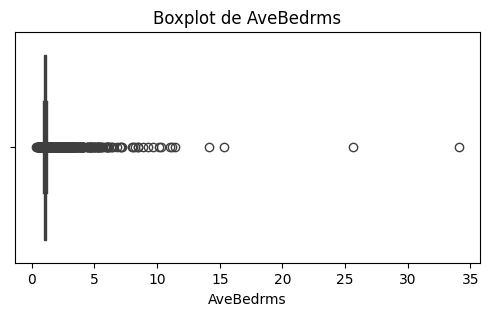

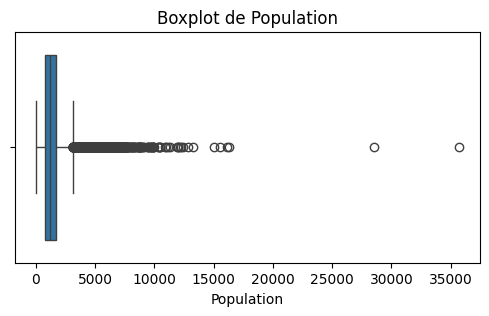

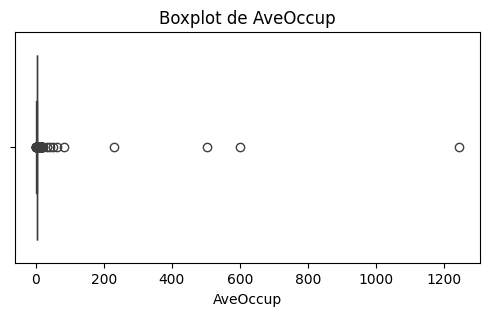

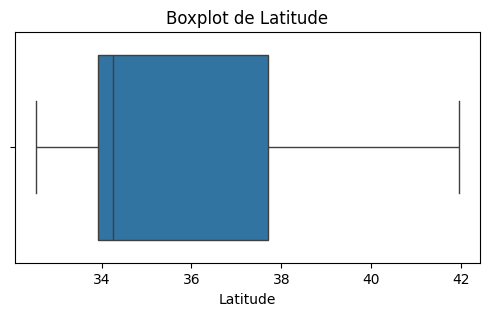

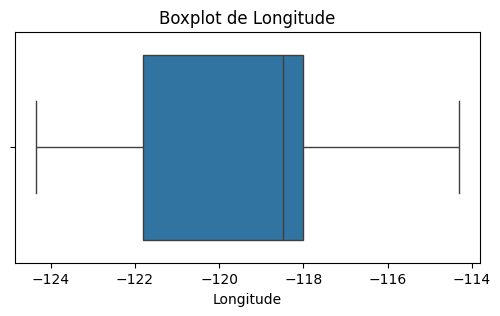

In [7]:
num_cols = X.columns  # solo features numéricas, sin la target

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()

Conclusión:
* Vemos outliers en AveBedrms pero hay que tener en cuenta que son realistas, porque el dataset no solo tiene en cuenta casas unifamiliares, si no que también los edificios (los trata como una sola vivienda)

### Matriz de correlación (numérica)

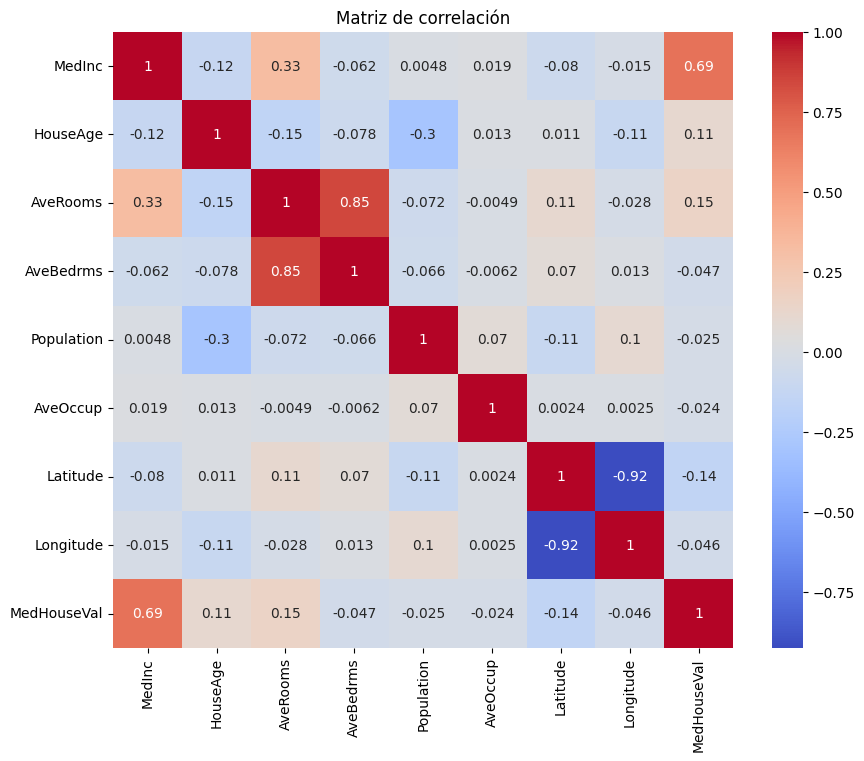

In [8]:
plt.figure(figsize=(10, 8))

corr = df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap="coolwarm")    # Representa la matriz de correlación como un mapa de calor (heatmap).
                                                  # 'annot=True' muestra los valores numéricos dentro de cada celda.
                                                  # 'cmap="coolwarm"' define la paleta de colores.
plt.title("Matriz de correlación")                # Añade un título descriptivo al gráfico.
plt.show()                                        # Muestra el gráfico en pantalla.


* `MedInc` es la variable más relacionada con el precio (clave)

  📌 **Correlación `MedInc` → `MedHouseVal` ≈ 0.69**

  👉 Conclusión:

  * Los **ingresos medios** son, con diferencia, el **mejor predictor lineal** del precio de la vivienda.
  * Tiene una relación **positiva y fuerte**.


* Hay **multicolinealidad fuerte** (`AveRooms` y `AveBedrms`)

  📌 **Correlación ≈ 0.85**

  👉 Conclusión:

  * Estas dos variables aportan información **muy similar**
  * En un modelo lineal pueden provocar:

    * coeficientes inestables
    * interpretaciones engañosas


* `Latitude` y `Longitude` están casi perfectamente correlacionadas (−0.92)

  👉 Conclusión:

  * Reflejan una **estructura geográfica**
  * La relación con el precio **no es lineal**
  * La regresión lineal **no puede capturar bien efectos espaciales**

Aunque en el EDA se detectan variables altamente correlacionadas entre sí (`AveRooms` y `AveBedrms`) y una fuerte relación espacial entre `Latitude` y `Longitude`, en este punto no se aplican transformaciones adicionales de feature engineering.  
Estas variables podrían tratarse en fases posteriores mediante eliminación, creación de nuevas features o modelos específicos para capturar relaciones no lineales.  


## Train/Test split

Separaremos el dataset en entrenamiento y test para evaluar generalización.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (16512, 8) (16512,)
Test : (4128, 8) (4128,)


## Preprocesamiento

En el EDA no detectamos valores nulos, duplicados, features categóricas por lo que lo único que debemos hacer es escalar.


In [10]:
num_cols = X.columns  # solo features numéricas

# Creamos el escalador
scaler = StandardScaler()

# Ajustamos el escalador SOLO con los datos de train (fit)
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Aplicamos la transformación a test (transform)
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Entrenamiento


In [11]:
# Creamos el modelo
lin_reg = LinearRegression()

# Entrenamos el modelo
lin_reg.fit(X_train, y_train)

# Predicciones sobre el conjunto de test
y_pred = lin_reg.predict(X_test)

## Evaluación

Calcularemos:
- MAE
- MSE
- R²


In [12]:
# MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculamos la relación con el rango del target para determinar cómo de bueno es el valor obtenido

# Paso 1️⃣ Calcular el rango del target
y_min = y_test.min()
y_max = y_test.max()

target_range = y_max - y_min
target_range

# Paso 2️⃣ Calcular el porcentaje del MAE respecto al rango
mae_pct = mae / target_range * 100

print(f"MAE: {mae:.3f}")
print(f"Rango del target: {target_range:.3f}")
print(f"MAE respecto al rango: {mae_pct:.1f}%")

MAE: 0.533
Rango del target: 4.850
MAE respecto al rango: 11.0%


**Conclusiones (MAE):**  

El modelo obtiene un **MAE de 0.533**, lo que indica que, de media, las predicciones se desvían aproximadamente medio punto respecto al valor real de la vivienda.  

El MAE representa aproximadamente un **11 % del rango de valores de la variable objetivo**, lo que se considera un resultado aceptable para un modelo baseline como la Regresión Lineal.

In [13]:
# Calculamos MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE:  {mse:.3f}")

MSE:  0.556


**Conclusiones (MSE):**  

El **MSE de 0.556** refleja la presencia de algunos errores relativamente grandes, especialmente en zonas con precios altos, ya que esta métrica penaliza más los errores extremos.  

El valor del **MSE** es similar al del **MAE**, lo que indica que el modelo no presenta una gran cantidad de errores extremadamente grandes.  
Si existieran muchos errores muy elevados, el MSE sería notablemente mayor que el MAE, ya que esta métrica penaliza de forma más severa los errores grandes.


In [14]:
r2 = r2_score(y_test, y_pred)
print(f"R²:   {r2:.3f}")

R²:   0.576


**Conclusiones (R²):**  

El **coeficiente de determinación (R² = 0.576)** indica que el modelo es capaz de explicar aproximadamente el 58 % de la variabilidad del precio de la vivienda.

En conjunto, la Regresión Lineal no captura toda la complejidad del problema, lo que sugiere que la relación entre las variables y la target no es puramente lineal y que modelos más flexibles podrían obtener mejores resultados.

### Análisis: Valores reales vs valores predichos

Cada punto representa una vivienda. El eje X es el valor real y el eje Y el valor que predice el modelo.

Si el modelo fuera perfecto, todos los puntos estarían sobre la diagonal.
En este caso vemos que el modelo sigue la tendencia, pero falla especialmente en viviendas caras, lo que indica que la relación no es puramente lineal.

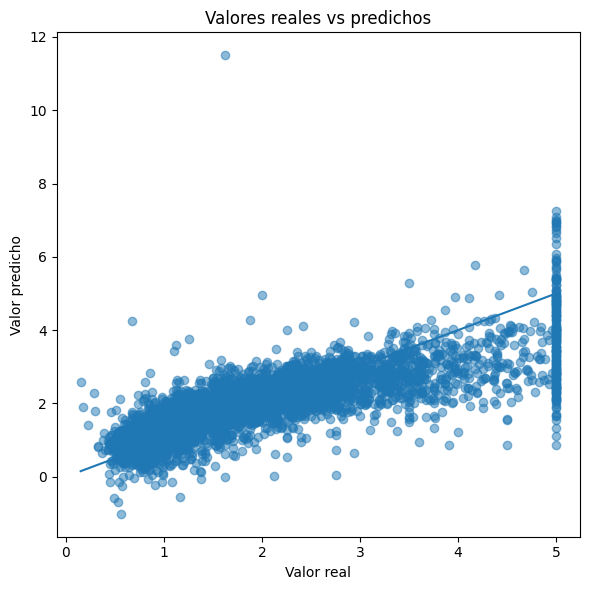

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Valores reales vs predichos")
plt.tight_layout()
plt.show()

**Conclusión (valores reales vs predichos):**  

En este gráfico, cada punto representa una observación del conjunto de test, donde el eje horizontal muestra el valor real y el eje vertical el valor predicho por el modelo.  
La línea diagonal representa la predicción perfecta: cuanto más cerca estén los puntos de esta línea, menor es el error de predicción.

En este caso, se observa que los puntos siguen una tendencia ascendente, lo que indica que el modelo es capaz de capturar la relación general entre las variables y la target. Sin embargo, existe una dispersión considerable alrededor de la línea, especialmente para valores altos, donde el modelo tiende a subestimar el precio de la vivienda.

Esta dispersión explica que el **coeficiente de determinación (R²)** no sea cercano a 1, ya que el modelo solo explica una parte de la variabilidad del precio.  
El objetivo de un buen modelo de regresión es conseguir que los puntos estén **lo más próximos posible a la línea diagonal**, lo que implicaría predicciones más precisas y un R² más alto.


### Análisis: Gráfico de residuos

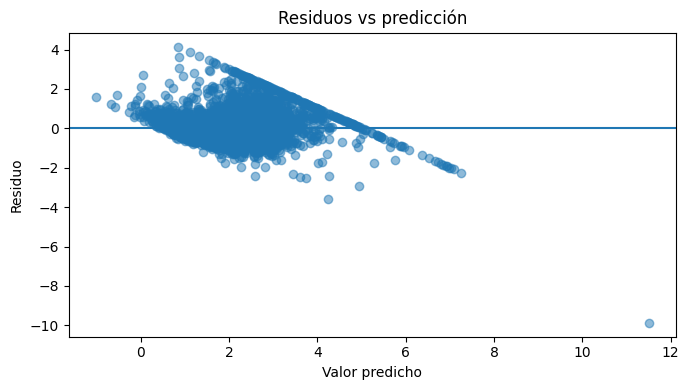

In [16]:
residuals = y_test - y_pred

plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0)
plt.xlabel("Valor predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs predicción")
plt.tight_layout()
plt.show()

**Conclusiones (gráfico de residuos vs predicción):**  

Los residuos no se distribuyen de forma aleatoria alrededor de cero, sino que presentan un patrón claro, lo que indica que el error del modelo depende del valor predicho.  
A medida que aumenta el valor predicho, los residuos tienden a ser negativos, lo que muestra una **subestimación sistemática** del valor real para viviendas de mayor precio.

Además, se observa una dispersión desigual de los residuos, con errores más grandes en determinados rangos, lo que sugiere que la relación entre las variables y la target **no es puramente lineal**.  
La presencia de algunos residuos muy alejados de cero indica errores grandes que influyen especialmente en métricas como el **MSE**.

En conjunto, este gráfico confirma que la Regresión Lineal capta la tendencia general, pero presenta limitaciones para modelar correctamente la complejidad del problema, justificando el uso de modelos más flexibles.

## Análisis de atributos útiles

En un modelo lineal, los coeficientes indican:
- signo (+/-): si la feature aumenta o disminuye la predicción
- magnitud: impacto relativo **si las variables están escaladas**

Como hemos escalado, la comparación entre magnitudes tiene sentido.


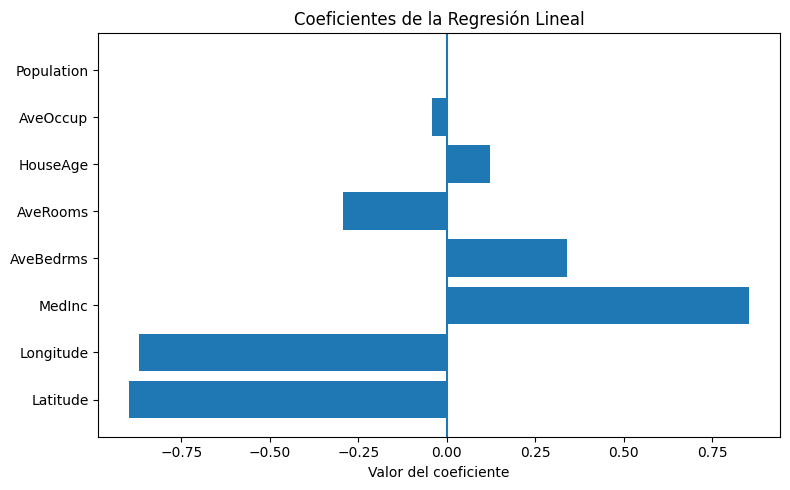

In [17]:
# Extraemos los coeficientes junto con los nombres de las variables
coef_df = pd.Series(
    lin_reg.coef_,
    index=X_train.columns
).sort_values(key=abs, ascending=False)

# Los mostramos en el gráfico
plt.figure(figsize=(8,5))
plt.barh(coef_df.index, coef_df.values)
plt.axvline(0)
plt.title("Coeficientes de la Regresión Lineal")
plt.xlabel("Valor del coeficiente")
plt.tight_layout()
plt.show()

**Conclusiones (coeficientes de la Regresión Lineal):**  

El coeficiente con mayor impacto positivo es **`MedInc`**, lo que indica que el ingreso medio de la zona es la variable que más incrementa el valor predicho de la vivienda. Esto confirma que es el predictor lineal más relevante del modelo.

Las variables **`Latitude`** y **`Longitude`** presentan coeficientes negativos de gran magnitud, lo que refleja una fuerte influencia de la localización geográfica.

Se observa también que **`AveRooms`** y **`AveBedrms`** tienen coeficientes de signo opuesto, lo que es indicativo de **multicolinealidad**. Al estar altamente correlacionadas entre sí, el modelo reparte el peso entre ambas, lo que puede dificultar la interpretación individual de sus coeficientes.

Variables como **`Population`** y **`AveOccup`** presentan coeficientes cercanos a cero, lo que sugiere que su influencia lineal directa sobre el precio es limitada dentro de este modelo.

En conjunto, el análisis de coeficientes muestra que la Regresión Lineal identifica correctamente las variables más importantes, pero también evidencia limitaciones debidas a relaciones no lineales y a la multicolinealidad, lo que justifica el uso de regularización y modelos más flexibles.

# KNN Regresión

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

## Entrenamiento

En este bloque se utiliza **GridSearchCV** para buscar de forma sistemática la mejor combinación de hiperparámetros del modelo **KNN Regressor**, evaluando su rendimiento mediante **validación cruzada**.

El modelo KNN no aprende parámetros durante el entrenamiento, por lo que su rendimiento depende en gran medida de la elección de sus hiperparámetros. En este caso, se prueban distintas configuraciones variando el número de vecinos (`n_neighbors`), que controla el grado de suavizado del modelo, y el tipo de pesos (`weights`), que determina si todos los vecinos influyen por igual o si los más cercanos tienen mayor peso en la predicción.

Para cada combinación de hiperparámetros, GridSearchCV realiza una **validación cruzada con 5 particiones** sobre el conjunto de entrenamiento. En cada iteración, el modelo se evalúa en datos no utilizados durante ese ajuste, y el rendimiento final se obtiene promediando los resultados de todas las particiones. Esto permite estimar de forma más fiable la capacidad de generalización del modelo, sin utilizar el conjunto de test.

Durante el proceso se calculan varias métricas de regresión (MAE, MSE y R²). Aunque todas se registran, se utiliza el **MAE** como criterio para seleccionar el mejor modelo, ya que es una métrica fácil de interpretar y menos sensible a errores extremos. En `scikit-learn`, las métricas de error se expresan con signo negativo, por lo que el valor mostrado se invierte para interpretarlo correctamente.

Al finalizar la búsqueda, se obtiene la combinación de hiperparámetros que minimiza el MAE medio en validación cruzada. Este modelo optimizado se utilizará posteriormente para evaluar el rendimiento final sobre el conjunto de test, que ha permanecido completamente separado durante todo el proceso de ajuste.


In [19]:
knn = KNeighborsRegressor()

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31],
    "weights": ["uniform", "distance"],
}

# Evaluamos con varias métricas y elegimos cuál usar para "refit"
scoring = {
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
    "R2": "r2",
}

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    refit="MAE",      # se queda como "mejor modelo" el que minimiza MAE (recuerda: negado)
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor CV MAE (en positivo):", -grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores hiperparámetros: {'n_neighbors': 7, 'weights': 'distance'}
Mejor CV MAE (en positivo): 0.4383333764244298


In [20]:
# Predecimos con el mejor modelo obtenido
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

## Evaluación

In [21]:
# MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculamos la relación con el rango del target para determinar cómo de bueno es el valor obtenido

# Paso 1️⃣ Calcular el rango del target
y_min = y_test.min()
y_max = y_test.max()

target_range = y_max - y_min
target_range

# Paso 2️⃣ Calcular el porcentaje del MAE respecto al rango
mae_pct = mae / target_range * 100

print(f"MAE: {mae:.3f}")
print(f"Rango del target: {target_range:.3f}")
print(f"MAE respecto al rango: {mae_pct:.1f}%")

MAE: 0.441
Rango del target: 4.850
MAE respecto al rango: 9.1%


**Conclusiones (MAE):**

El modelo obtiene un **MAE de 0.441**, lo que indica que, de media, las predicciones se desvían algo menos de medio punto respecto al valor real de la vivienda.

El MAE representa aproximadamente un **9.1 % del rango de valores de la variable objetivo**, lo que supone una **mejora respecto a la Regresión Lineal** y sugiere que KNN Regresión es capaz de capturar **relaciones no lineales** presentes en los datos.

Este resultado confirma que, para este problema, un modelo basado en vecinos puede ofrecer un rendimiento superior al modelo lineal, aunque a costa de **menor interpretabilidad** y **mayor coste computacional en la predicción**.


In [22]:
# Calculamos MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE:  {mse:.3f}")

MSE:  0.424


**Conclusiones (MSE):**

El **MSE de 0.424** es inferior al obtenido con la Regresión Lineal, lo que indica una **reducción en la magnitud de los errores grandes**. Dado que esta métrica penaliza de forma más severa las desviaciones elevadas, el resultado sugiere que KNN Regresión gestiona mejor las predicciones en zonas con valores extremos del precio de la vivienda.

La diferencia entre **MSE y MAE** no es excesiva, lo que indica que el modelo no presenta una gran cantidad de errores extremadamente grandes, sino que los errores están relativamente bien distribuidos.

In [23]:
r2 = r2_score(y_test, y_pred)
print(f"R²:   {r2:.3f}")

R²:   0.677


**Conclusiones (R²):**

El **coeficiente de determinación (R² = 0.677)** indica que el modelo es capaz de explicar aproximadamente el **68 % de la variabilidad del precio de la vivienda**, lo que supone una mejora clara respecto a la Regresión Lineal.

En conjunto, estos resultados confirman que **KNN Regresión captura mejor la complejidad del problema**, modelando relaciones no lineales que la Regresión Lineal no es capaz de representar, a cambio de una **menor interpretabilidad** y un **mayor coste computacional en la fase de predicción**.


### Análisis: Valores reales vs predichos

¡OJO! La línea del gráfico no es el modelo KNN.
Representa la predicción perfecta (valor real = valor predicho) y se dibuja solo como referencia visual.

KNN no aprende una recta ni una función global; el modelo realiza predicciones punto a punto usando vecinos.
El gráfico sirve únicamente para ver qué tan cerca están las predicciones del valor ideal, no para mostrar la forma del modelo.

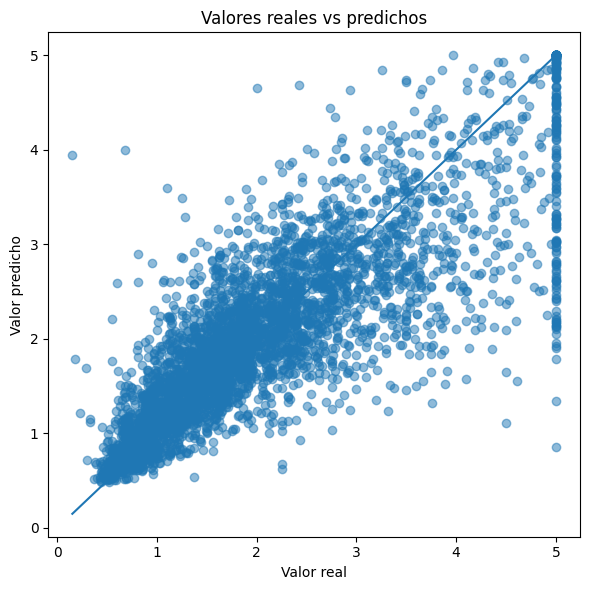

In [24]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Valores reales vs predichos")
plt.tight_layout()
plt.show()

**Conclusiones (valores reales vs predichos):**

El gráfico muestra una **tendencia claramente alineada con la diagonal**, lo que indica que el modelo KNN Regresión es capaz de capturar de forma adecuada la relación entre las variables de entrada y el valor de la vivienda. La mayor concentración de puntos alrededor de la diagonal confirma un **buen ajuste global**, coherente con los valores obtenidos en MAE, MSE y R².

Se observa una **mayor dispersión en los valores extremos**, especialmente para viviendas con precios altos. Este comportamiento es habitual en KNN, ya que las predicciones en zonas con menor densidad de datos dependen de menos vecinos cercanos y tienden a suavizarse.

En la zona central del rango de precios, donde existe una mayor densidad de observaciones, el modelo presenta **predicciones más precisas y estables**, lo que sugiere que KNN funciona especialmente bien en regiones densas del espacio de datos.

En conjunto, el gráfico confirma que KNN Regresión mejora el ajuste respecto a la Regresión Lineal, aunque mantiene cierta dificultad para predecir con alta precisión los valores más extremos del target.

### Análisis: Gráfico de residuos

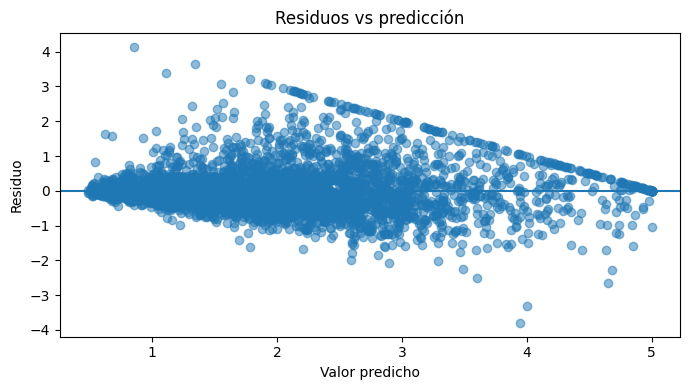

In [25]:
residuals = y_test - y_pred

plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0)
plt.xlabel("Valor predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs predicción")
plt.tight_layout()
plt.show()

**Conclusiones (residuos vs predicción):**

El gráfico muestra que los **residuos se distribuyen alrededor de cero**, lo que indica que el modelo KNN Regresión **no presenta un sesgo sistemático fuerte** en sus predicciones globales.

Se observa, sin embargo, una **mayor dispersión de los residuos a medida que aumenta el valor predicho**, especialmente en la zona de precios más altos. Este patrón es habitual en KNN y sugiere que el modelo tiene más dificultad para predecir con precisión en regiones donde hay **menos densidad de datos**.

En los valores intermedios del target, donde se concentra la mayoría de las observaciones, los residuos son **más pequeños y homogéneos**, lo que confirma que el modelo funciona mejor en las regiones densas del espacio de datos.

En conjunto, el gráfico indica que KNN Regresión ofrece un buen ajuste general, aunque mantiene cierta **heterogeneidad en el error** para valores altos de la variable objetivo.

# Comparación LR vs KNN


| Modelo               | MAE       | MSE       | R²        | Conclusiones                                                                                                                                                                                  |
| -------------------- | --------- | --------- | --------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Regresión Lineal** | 0.533     | 0.556     | 0.576     | Modelo baseline sencillo. Captura la tendencia global, pero no logra modelar relaciones no lineales ni ajustarse bien a zonas complejas del espacio de datos.                 |
| **KNN Regresión**    | **0.441** | **0.424** | **0.677** | Mejora clara en todas las métricas. Captura relaciones no lineales y funciona mejor en regiones densas, aunque presenta menor interpretabilidad y mayor coste computacional en la predicción. |


# Decision Tree Regression

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
# Estos modelos se interpretan mejor sin escalado, así que hago otra vez el split para tener variables limpias
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train_raw.shape, y_train_raw.shape)
print("Test :", X_test_raw.shape, y_test_raw.shape)


Train: (16512, 8) (16512,)
Test : (4128, 8) (4128,)


## Entrenamiento

Los valores incluidos en el `param_grid` **no son universales ni mágicos**, sino rangos razonables que permiten explorar distintos **niveles de complejidad del árbol**. El objetivo del GridSearch es encontrar un equilibrio entre un modelo demasiado simple (underfitting) y uno demasiado complejo (overfitting), probando configuraciones representativas.

El parámetro `max_depth` controla la profundidad máxima del árbol: valores pequeños generan árboles simples y fáciles de interpretar, mientras que valores grandes (o `None`) permiten modelos muy complejos con mayor riesgo de sobreajuste. `min_samples_split` indica el número mínimo de muestras necesarias para dividir un nodo, evitando que el árbol siga creciendo cuando hay pocos datos, y `min_samples_leaf` fija el número mínimo de observaciones que debe tener una hoja, lo que ayuda a que las predicciones sean más robustas y menos sensibles al ruido.

Por su parte, `max_features` determina cuántas variables puede considerar el árbol en cada división: usar todas las variables (`None`) hace el modelo más determinista y propenso al overfitting, mientras que opciones como `"sqrt"` o `"log2"` limitan el número de variables y reducen la varianza del modelo introduciendo cierta aleatoriedad.

Estos valores suelen funcionar bien como **punto de partida** en datasets tabulares como California Housing, pero no sirven para todos los problemas. El GridSearch no busca el mejor árbol en general, sino el mejor árbol **para ese dataset concreto**, y los rangos deben adaptarse al tamaño y a las características de los datos.


In [28]:
# 1) Modelo base
dt = DecisionTreeRegressor(random_state=42)

# 2) Grid de hiperparámetros (centrado en controlar complejidad)
param_grid = {
    "max_depth": [None, 2, 3, 4, 5, 8, 12, 16],
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "max_features": [None, "sqrt", "log2"],
}

# 3) GridSearch con validación cruzada
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # minimizamos MSE
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_raw, y_train_raw)

print("✅ Mejores hiperparámetros:", grid.best_params_)
print("✅ Mejor CV (MSE):", -grid.best_score_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
✅ Mejores hiperparámetros: {'max_depth': 16, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 50}
✅ Mejor CV (MSE): 0.3594067301162015


In [29]:
# Predecimos con el mejor modelo obtenido
best_dt = grid.best_estimator_
y_pred = best_dt.predict(X_test_raw)

## Análisis del modelo obtenido

### Visualización del árbol

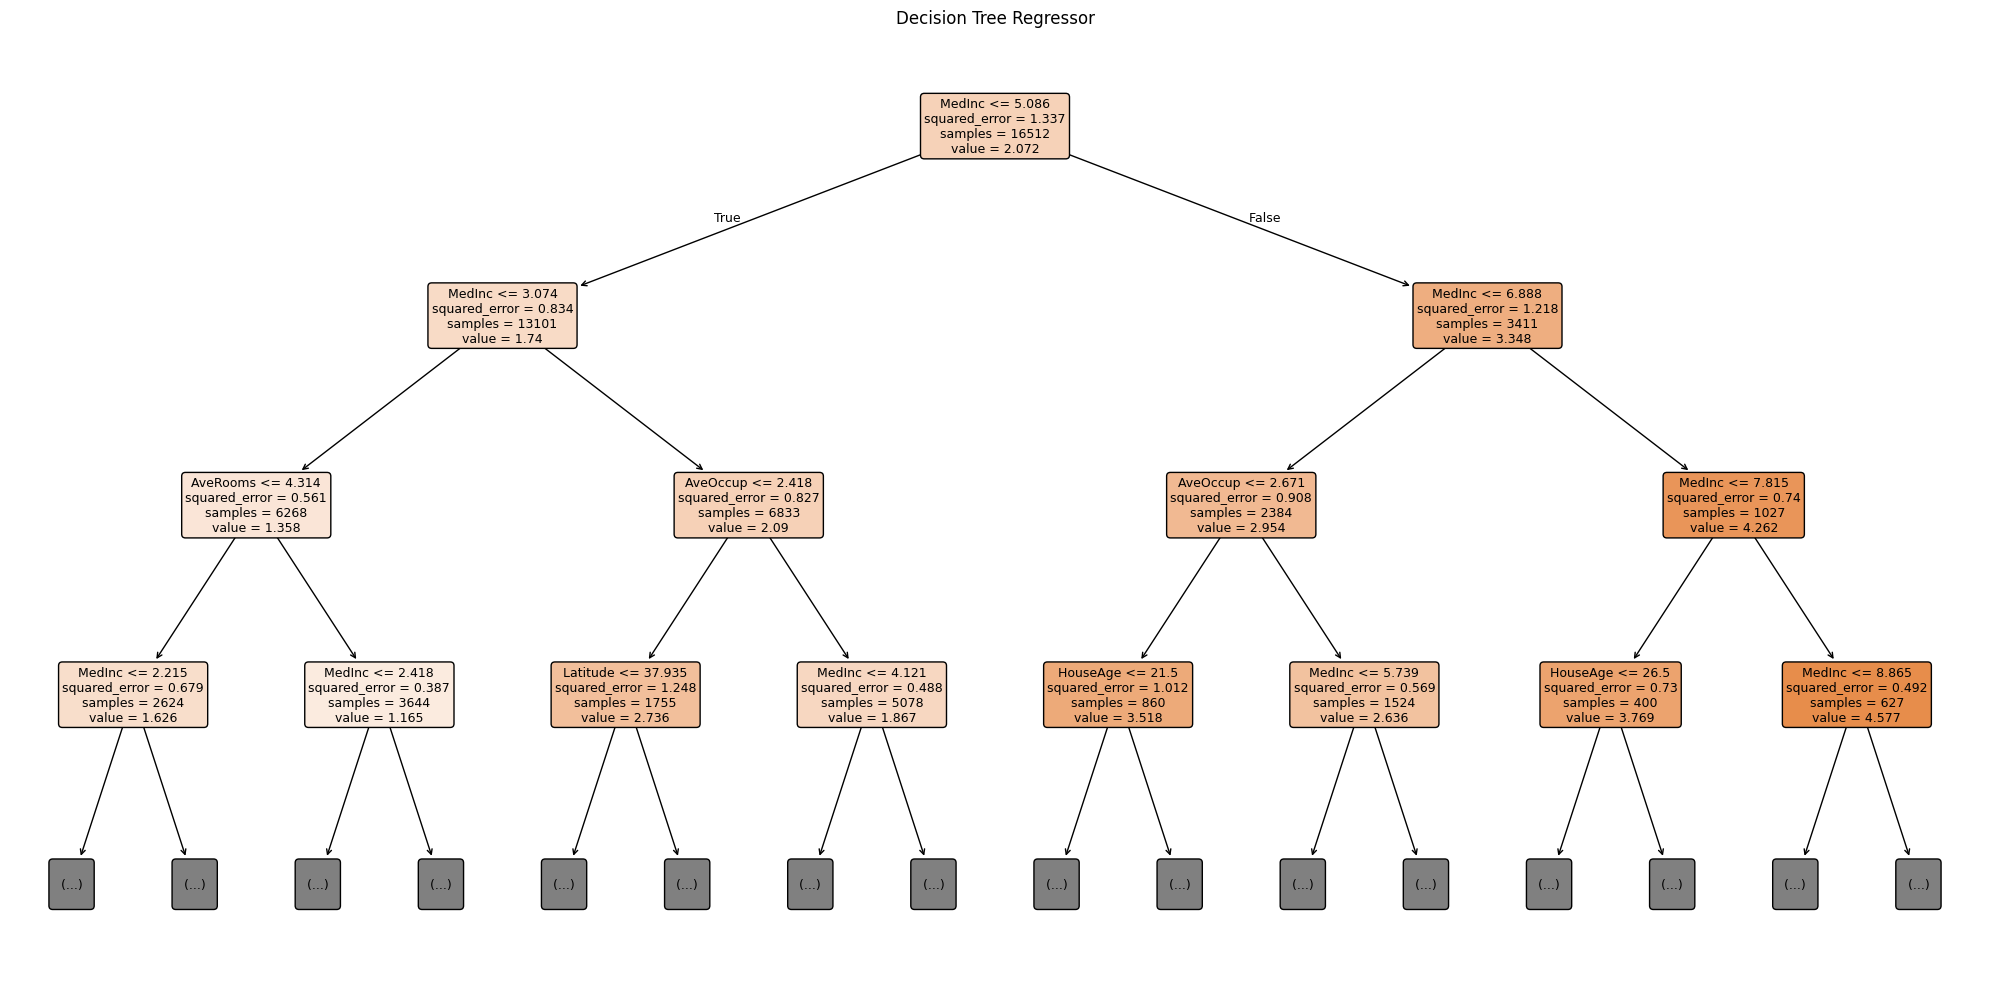

In [31]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    best_dt,
    feature_names=getattr(X_train_raw, "columns", None),
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=3  # Limitamos la profundidad para una mejor visualización
)
plt.title("Decision Tree Regressor")
plt.tight_layout()
plt.show()

### Análisis de importancia

      feature  importance
0      MedInc    0.617286
5    AveOccup    0.132618
6    Latitude    0.081070
7   Longitude    0.070103
1    HouseAge    0.045554
2    AveRooms    0.036813
3   AveBedrms    0.009495
4  Population    0.007063


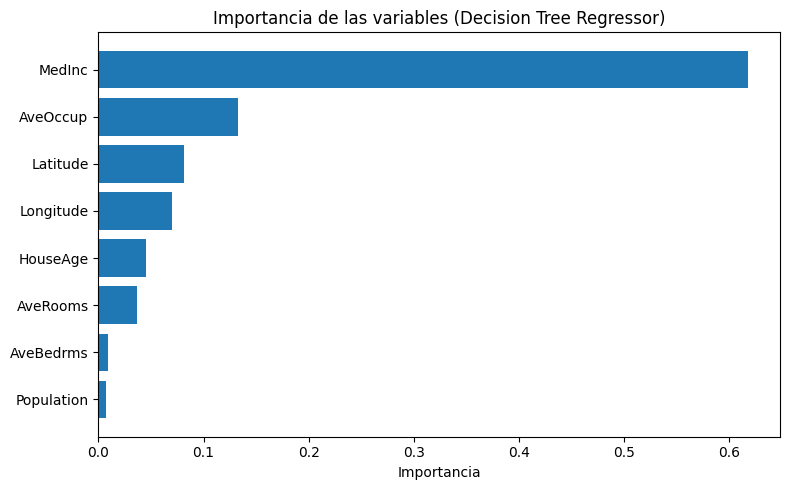

In [34]:
# Importancia de variables del mejor modelo
importances = best_dt.feature_importances_

# Nombres de las features (si X es DataFrame)
feature_names = X_train_raw.columns

# DataFrame ordenado para una mejor visualización
feature_importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

# Gráfica de barras
plt.figure(figsize=(8, 5))
plt.barh(
    feature_importance_df["feature"],
    feature_importance_df["importance"]
)
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de las variables (Decision Tree Regressor)")
plt.tight_layout()
plt.show()

El modelo basa gran parte de sus decisiones en **MedInc**, que concentra con mucha diferencia la mayor importancia, lo que indica que el ingreso medio del área es el factor más influyente para predecir el precio de la vivienda en este dataset. Variables como **AveOccup**, **Latitude** y **Longitude** tienen una influencia secundaria, aportando información adicional relacionada con la densidad de población y la ubicación geográfica. El resto de variables (**HouseAge**, **AveRooms**, **AveBedrms** y **Population**) tienen un peso reducido, lo que sugiere que apenas contribuyen a reducir el error del modelo. En conjunto, el árbol se apoya en pocas variables clave, lo que es habitual en este tipo de modelos y explica por qué son relativamente interpretables, aunque también puede indicar riesgo de sobreajuste si una sola variable domina en exceso.

## Evaluación

In [35]:
from sklearn.metrics import mean_absolute_error

# MAE
mae = mean_absolute_error(y_test_raw, y_pred)

# Paso 1️⃣ Calcular el rango del target
y_min = y_test_raw.min()
y_max = y_test_raw.max()

target_range = y_max - y_min

# Paso 2️⃣ Calcular el porcentaje del MAE respecto al rango
mae_pct = mae / target_range * 100

print(f"MAE: {mae:.3f}")
print(f"Rango del target: {target_range:.3f}")
print(f"MAE respecto al rango: {mae_pct:.1f}%")

MAE: 0.400
Rango del target: 4.850
MAE respecto al rango: 8.2%


**Conclusiones (MAE):**

El modelo obtiene un **MAE de 0.400**, lo que indica que, de media, las predicciones del árbol de decisión se desvían alrededor de **cuatro décimas** respecto al valor real de la vivienda.

Este error representa aproximadamente un **8.2 % del rango de valores de la variable objetivo**, lo que supone un **buen nivel de precisión** para este dataset y muestra una **mejora clara frente a la Regresión Lineal**.

El resultado sugiere que el **Árbol de Decisión para Regresión** es capaz de capturar **relaciones no lineales** presentes en los datos, ofreciendo además una **mayor interpretabilidad** que otros modelos no lineales como KNN, aunque con el riesgo de **sobreajuste** si no se controla adecuadamente la complejidad del modelo.

In [36]:
# Calculamos MSE
mse = mean_squared_error(y_test_raw, y_pred)
print(f"MSE:  {mse:.3f}")

MSE:  0.356


**Conclusiones (MSE):**

El **MSE de 0.356** es inferior al obtenido con la Regresión Lineal, lo que indica una **reducción en la magnitud de los errores más grandes**. Dado que esta métrica penaliza de forma más severa las desviaciones elevadas, el resultado sugiere que el **Árbol de Decisión para Regresión** gestiona mejor las predicciones en zonas donde el precio de la vivienda presenta valores más extremos.

La diferencia entre **MSE y MAE** no es excesiva, lo que indica que el modelo no está cometiendo un gran número de errores muy grandes, sino que los errores se encuentran **razonablemente bien distribuidos**, reforzando la idea de que el modelo ofrece un rendimiento equilibrado cuando se controla adecuadamente su complejidad.

In [37]:
r2 = r2_score(y_test_raw, y_pred)
print(f"R²:   {r2:.3f}")

R²:   0.728


**Conclusiones (R²):**

El **coeficiente de determinación (R² = 0.728)** indica que el modelo es capaz de explicar aproximadamente el **73 % de la variabilidad del precio de la vivienda**, lo que supone una **mejora clara respecto a la Regresión Lineal**.

En conjunto, estos resultados confirman que el **Árbol de Decisión para Regresión** captura de forma efectiva la **complejidad y no linealidad del problema**, ofreciendo además una **mayor interpretabilidad** que otros modelos no lineales como KNN, aunque con la necesidad de **controlar su complejidad** para evitar el sobreajuste.

### Análisis: Valores reales vs predichos

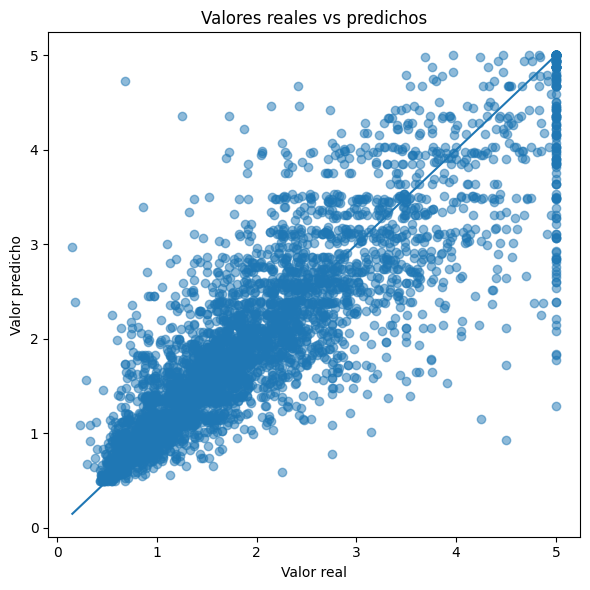

In [38]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_raw, y_pred, alpha=0.5)
plt.plot([y_test_raw.min(), y_test_raw.max()],
         [y_test_raw.min(), y_test_raw.max()])
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Valores reales vs predichos")
plt.tight_layout()
plt.show()

**Conclusiones (valores reales vs predichos):**

El gráfico muestra una **relación clara y positiva** entre los valores reales y los valores predichos, lo que indica que el modelo es capaz de capturar de forma adecuada la tendencia general del precio de la vivienda. La mayoría de los puntos se concentran alrededor de la línea diagonal, especialmente en el rango medio de valores, lo que sugiere un **buen ajuste global**.

Sin embargo, se observa una mayor dispersión a medida que aumentan los valores reales, lo que indica que el modelo comete **errores más elevados en viviendas de precio alto**. Además, la acumulación de puntos con predicciones similares refleja la naturaleza del árbol de decisión, que genera **predicciones por tramos** al asignar valores constantes en cada hoja. En conjunto, el modelo ofrece un rendimiento sólido, aunque muestra ciertas limitaciones para ajustar con precisión los valores extremos.

### Análisis: Gráfico de residuos

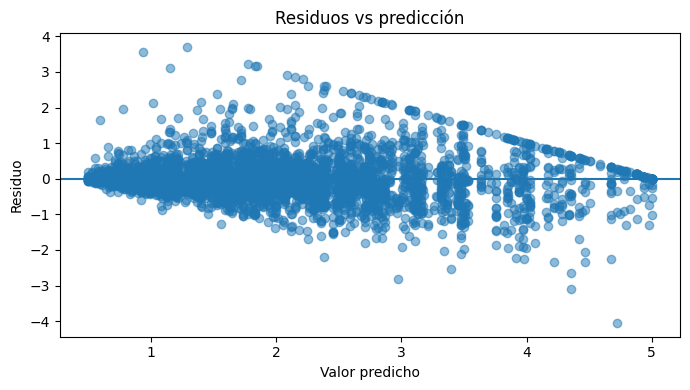

In [39]:
residuals = y_test_raw - y_pred

plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0)
plt.xlabel("Valor predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs predicción")
plt.tight_layout()
plt.show()

**Conclusiones (residuos vs predicción):**

El gráfico de residuos muestra que los errores se distribuyen alrededor de cero para valores bajos y medios de la predicción, lo que indica que el modelo no presenta un sesgo sistemático importante en esa zona. La mayor concentración de puntos cerca de la línea horizontal sugiere que, en promedio, las predicciones son razonables.

Sin embargo, se observa un **patrón claro en forma de abanico** a medida que aumenta el valor predicho, con una mayor dispersión de los residuos. Esto sugiere que el modelo tiene más dificultad para ajustar correctamente las viviendas de mayor precio.

# Comparación LR vs KNN vs Decision Tree

| Modelo                | MAE       | MSE       | R²        | Conclusiones                                                                                                                                                                                                                                  |
| --------------------- | --------- | --------- | --------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Regresión Lineal**  | 0.533     | 0.556     | 0.576     | Modelo baseline sencillo. Captura la tendencia global, pero no logra modelar relaciones no lineales ni ajustarse bien a zonas complejas del espacio de datos.                                                                                 |
| **KNN Regresión**     | 0.441     | 0.424     | 0.677     | Mejora clara en todas las métricas. Captura relaciones no lineales y funciona mejor en regiones densas, aunque presenta menor interpretabilidad y mayor coste computacional en la predicción.                                                 |
| **Árbol de Decisión** | **0.400** | **0.356** | **0.728** | Es el modelo con mejor rendimiento global. Captura de forma eficaz la no linealidad del problema y mejora claramente a LR y KNN, ofreciendo además mayor interpretabilidad, aunque requiere controlar su complejidad para evitar sobreajuste. |